In [19]:
import os
import re
import sklearn
import numpy as np
import pandas as pd
from wombat.engine import ml_model
from wombat.engine import parse_input_description as parse_title
from wombat.models import Item
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestRegressor
from wombat.models import dbsession, engine, ItemType, ItemAdjective
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,12)

# suppress pandas warning about operations on copies of dfs
pd.options.mode.chained_assignment = None

In [37]:
df = ml_model.canonical_df
df = df.loc[df['item_type'] == 'dresses']
df = df.loc[df.isnull().any(axis=1) == False]
df.reset_index()
print(df.shape)
# split data into train and test group
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75

# copy of train before we delete the 'rent_per_week' and 'title' field. We want title 
# we will need these things before we make dummy variables
df_full_training = df[df['is_train']==True]
df_full_test = df[df['is_train']==False]

# get one-hot columns for brands 
dummy_brands = pd.get_dummies(df['brand'])
df = pd.concat([df, dummy_brands], axis = 1)
df = df.drop('brand', axis = 1)

# get one-hot columns for item_types
dummified_items = pd.get_dummies(df['item_type'])
df = pd.concat([df, dummified_items], axis = 1)
df = df.drop(['item_type'], axis = 1)
df.shape

(4500, 7)


(4500, 1363)

In [38]:
# get list of adjective features form database
features_adj = [f.name for f in dbsession.query(ItemAdjective).all()]
item_types   = [item.name for item in dbsession.query(ItemType).all()]

tokenized_titles = []
for title in df['title']:
    parse_title.create_one_hot_row_adj(title, features_adj)
    tokenized_titles.append(parse_title.create_one_hot_row_adj(title, features_adj))
df_adj = pd.DataFrame(tokenized_titles, columns = features_adj)

features_adj = [f.name for f in dbsession.query(ItemAdjective).all()]

item_types   = [item.name for item in dbsession.query(ItemType).all()]

#tokenized_titles = []
#for text_array in df[['title', 'description']].values:
#    try:
#        text = ' '.join(text_array)
#    except TypeError:
#        text = title
#    #parse_title.create_one_hot_row_adj(text, features_adj)
#    tokenized_titles.append(parse_title.create_one_hot_row_adj(text, features_adj))
#df_adj = pd.DataFrame(tokenized_titles, columns = features_adj)
df_adj.shape

(4500, 163)

In [44]:
print(df_adj.index)
print(df.index)
df = pd.concat([df, df_adj], axis = 1)
df.shape

RangeIndex(start=0, stop=4500, step=1)
Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            5752, 5753, 5754, 5755, 5756, 5757, 5758, 5759, 5760, 5761],
           dtype='int64', length=5636)


(5636, 2178)

In [15]:
features = df.columns.drop(['rent_per_week', 'title', 'cost', 'is_train', 'description']) # just column names
train, test = df[df['is_train']==True], df[df['is_train']==False]
train.columns

Index(['title', 'cost', 'rent_per_week', 'description', 'is_train',
       '  Dolce & Gabbana', ' Adrianna Papell', ' Alexia Admor',
       ' Amanda Uprichard', ' Basix II',
       ...
       'gala', 'runway', 'ball', 'costume', 'iconic', 'cavier', 'peacock',
       'florence', 'mermaid', 'jersey'],
      dtype='object', length=1545)

In [16]:
y = train['rent_per_week']
#print("Shape of test df: {}".format(test.shape))
#print('Number of observations in the test data: {}'.format(df_full_test.shape))
from sklearn import svm, linear_model

#clf = svm.SVR() # didn't work. Predicted 43 for everything
clf = RandomForestRegressor(n_jobs=2, n_estimators=15)
clf.fit(train[features], train['rent_per_week'])
#rfr_predicted = clf.predict(test[features])
#reg = linear_model.LinearRegression() # total crap
#reg = linear_model.Ridge(alpha = .5) # comparable to rfr
#reg = linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0]) # comparable to rfr 
#reg = linear_model.Lasso(alpha = 0.1)
#reg = linear_model.ElasticNet(alpha=0.1) # comparable to rfr 
#reg = linear_model.RANSACRegressor(linear_model.LinearRegression()) # slow, did not finish, uses lots of cpu
#reg = linear_model.TheilSenRegressor() # slow, did not finish, uses lots of cpu

#reg = linear_model.HuberRegressor() # slow, did not finish, uses lots of cpu

reg.fit(train[features], train['rent_per_week'])
rfr_predicted = clf.predict(test[features])

model_dir = '/home/patrick/Dropbox/insight/wombat/wombat/engine/stat_model_pickles'
model_path = os.path.join(model_dir, 'rfr_v0.1_no_adj.pkl')
joblib.dump(reg, model_path)
#call this with: clf = joblib.load('huber_v0.1.pkl')
#rfr_predicted


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [6]:
print(len(clf.feature_importances_))
print(len(train.columns))

1709
1714


In [7]:
reg = linear_model.LinearRegression() # total crap
#reg = linear_model.Ridge(alpha = .5) # comparable to rfr but much faster to compute
#reg = linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0]) # comparable to rfr 
#reg = linear_model.Lasso(alpha = 0.1)
#reg = linear_model.ElasticNet(alpha=0.1) # comparable to rfr 
#reg = linear_model.RANSACRegressor(linear_model.LinearRegression()) # slow, did not finish, uses lots of cpu
#reg = linear_model.TheilSenRegressor() # slow, did not finish, uses lots of cpu

#reg = linear_model.HuberRegressor() # slow, did not finish, uses lots of cpu



In [61]:
features.values
coef_df = pd.DataFrame(reg.coef_, columns = features.values)


AttributeError: 'LinearRegression' object has no attribute 'coef_'

In [9]:
reg.fit(train[features], train['rent_per_week'])
r2 = reg.score(train[features], train['rent_per_week'])
rfr_predicted = reg.predict(test[features])
r2

0.63909411656653037

In [ ]:
from sklearn import linear_model

# Create linear regression object for predicted vs measured
reg = linear_model.LinearRegression()

x = test['rent_per_week'].values.reshape(-1,1)
y = np.array(rfr_predicted)

# Train the model using the training sets
reg.fit(x, y)
# The coefficients
print('Coefficients: ', reg.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((reg.predict(x) - y) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % reg.score(x, y))

# Plot outputs
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(x = test['rent_per_week'], y = rfr_predicted)
#stopping_value = np.minimum(test['rent_per_week'].max, np.maximum(rfr_predicted))
stopping_value = 300
ax.plot([0, stopping_value], [0, stopping_value], 'k--', lw=4)
ax.set_title('Errors for Random Forest Regression')
ax.set_xlabel('Observed', fontsize=18)
ax.set_ylabel('Predicted', fontsize=18)
#ax.plot(x, reg.predict(x), 'k--', color='blue', linewidth=3)

#ax.text(0, 70, 'Coefficients: {}'.format(reg.coef_), style='italic', fontsize=16,
       # bbox={'facecolor':'blue', 'alpha':0.2, 'pad':10})
#ax.text(0,500, "Mean squared error: %.2f"
      #% np.mean((reg.predict(x) - y) ** 2), style='italic', fontsize=16,
      #  bbox={'facecolor':'blue', 'alpha':0.2, 'pad':10})
#ax.text(20, 100, 'Variance score: %.2f' % reg.score(x, y), style='italic', fontsize=16,
     #   bbox={'facecolor':'blue', 'alpha':0.2, 'pad':10})

x = test['rent_per_week']
df_full_test['predicted_rent'] = rfr_predicted
#df_full_test['error'] = df_full_test[['rent_per_week', 'predicted_rent']].subtract(axis=1)
df_full_test['error'] = df_full_test['rent_per_week'] - df_full_test['predicted_rent']
print("Length of df_full_test: {}".format(len(df_full_test)))
df_full_test['error'] = df_full_test['error'].abs()
#df_error = df_full_test.loc[df_full_test['error']>0][['brand', 'item_type', 'title', 'error', 'description']].sort_values('error', ascending = 0)
#reg.score(x, y)
print("Length of df_error: {}".format(len(df_error)))

In [115]:
pd.set_option('display.max_colwidth', -1)

#d_errors = df_error.sort_values('error', ascending=False)
binwidth = 50
bins = list(range(0, 1000 + binwidth, binwidth))
l = []
#for i in bins:
#    y = len(d[d['error'] < i+1]) & (d[d['error'] >= i]))
#    x = i
#    l.append((x,y))
#lower = 0
#upper = 50
#d_errors = df_error.sort_values('error', ascending=True)
#num_high_errors = d_errors[(d_errors['error'] > 30) & (d_errors['error'] < 1000)]
#len(num_high_errors)
#num_low_errors = d_errors[(d_errors['error'] > 0) & (d_errors['error'] < 10)]
#print(len(num_low_errors)/len(num_high_errors))
#print(len(num_low_errors)/len(d_errors))
#print(len(num_low_errors))
d_errors = df_full_test
num_low_errors = d_errors[(d_errors['error'] > 0) & (d_errors['error'] < 20)]
num_high_errors = d_errors[(d_errors['error'] > 20) & (d_errors['error'] < 1000)]
print(len(num_low_errors))
print(len(num_low_errors)/len(d_errors))
print(len(num_high_errors))
d_errors = df_full_test.sort_values('error', ascending=True)
d_errors

1171
0.7838018741633199
322


,brand,item_type,title,cost,rent_per_week,description,is_train,predicted_rent,error
4165,Diane Von Furstenberg,dresses,Naira Printed Crepe Silk Dress,582.00,40.0,"This crepe silk dress by Diane Von Furstenberg has all over print, overlayed cowl neck and a matching elasticated waistbelt with silver clasp fastening. The dress slips on with two seam pockets at the hips.\n\nThe pattern is an African tulip print. The dress has side pockets, easily slips-on and comes with a matching waist-tie. 100% silk. Dry Clean Only.",False,40.005507,0.005507
4108,Jay Godfrey,dresses,Sheer Panel Crepe Jumpsuit,398.00,44.0,This on-trend jumpsuit will make jaws drop with a strategically sheer-and-opaque paneled bodice that highlights the bust. Pleats below the banded natural waist release fluid wide-cut legs that beautifully balance the fitted top half.,False,43.993737,0.006263
1489,Reformation,outerwear,The Opera Bolero,258.00,40.0,"Cropped velvet with a neck tie, yes please. The Opera Bolero is the perfect little guy to keep you looking good on those colder days. This is a slightly padded velvet bolero with long sleeves and an adjustable tie. Fully lined. The fit is snug but not tight, so you've got room to layer. \nComposition:100% Surplus Fabric",False,40.011111,0.011111
2568,Carmella,dresses,Clara Maxi Dress with Shirring,531.00,64.0,Several lacquered buttons line the placket of this romantic maxi dress,False,64.026667,0.026667
902,Elie Tahari,dresses,Black Silk Mini Dress,200.00,40.0,"Black rouched mini perfect for a special night out. Great dress, the rouching covers any imperfections!",False,39.973326,0.026674
4639,Three Floor,dresses,Look See Dress,261.00,44.0,Fit and flare dress with pleated skirt and mesh accents + side cutouts. Inspired by Refinery29 list of a dress for every occasion. \n\nPHOTO CREDIT: Wheretoget.it,False,44.028913,0.028913
385,Fendi,shoes,Buckled Up,850.00,70.0,Step out in these Fendi boots to make a killer statement.,False,69.933333,0.066667
4741,Michael by Michael Kors,dresses,Navy Lover,185.00,36.0,"Modern Michael Kors Navy Jumpsuit, designed with v-neckline, sleeveless, elastic waistband, pockets on side. Can be worn with tape to have a deeper cut, snap inclosure for more modest look. Stretches to fit a size 2-4. Model: 5'8"". Composition: 100% Polyester.",False,36.066667,0.066667
2877,Erin Fetherston,dresses,Mariposa Maxi Dress,395.00,45.0,Metallic butterfly maxi dress in blush by Erin Fetherston. This gorgeous dress is sleeveless with a halter neckline that runs true to size. A-line body with sheer skirt. \n\nPhoto: Dressometry.com,False,45.076667,0.076667
1522,FAVIANA,dresses,Embellished Chiffon Fit & Flare Dress,298.00,45.0,"Sculpted by shirring and banded in rhinestone, this formal cocktail dress is beautifully balanced by a fitted surplice bodice and a free-flowing skirt.",False,45.081111,0.081111


In [60]:
df_error[df_error['brand']=='Yves Saint Laurent']

,brand,item_type,title,error,description
3775,Yves Saint Laurent,bags,Timeless & Classic Clutch,216.5,This classic YSL clutch will be perfect for yo...
3678,Yves Saint Laurent,shoes,Palais Suede and Python Sandals,117.5,Yves Saint Laurent Palais sandals: almond peep...


In [61]:
 # make plotly plot
import plotly.plotly as py
import plotly.graph_objs as go

brands = df_full_training['brand'].values
item_types = df_full_training['item_type'].values
titles = df_full_training['title'].values
labels = []
for i in list(range(0, len(brands))):
    labels.append("{}, {}, {}".format(brands[i], item_types[i], titles[i]))

data = [
    go.Scatter(
        x=test['rent_per_week'],
        y=rfr_predicted,
        mode='markers',
        text=labels
    )
]
layout = go.Layout(
    title='Measured vs Predicted outcomes using Random Forest model'
)
fig = go.Figure(data=data, layout=layout)
plot_url = py.plot(fig, filename='meas-v-pred-rfr-2017-06-12')

Coefficients: 
 [ 0.21280168]
Mean squared error: 508.92
Variance score: 0.10


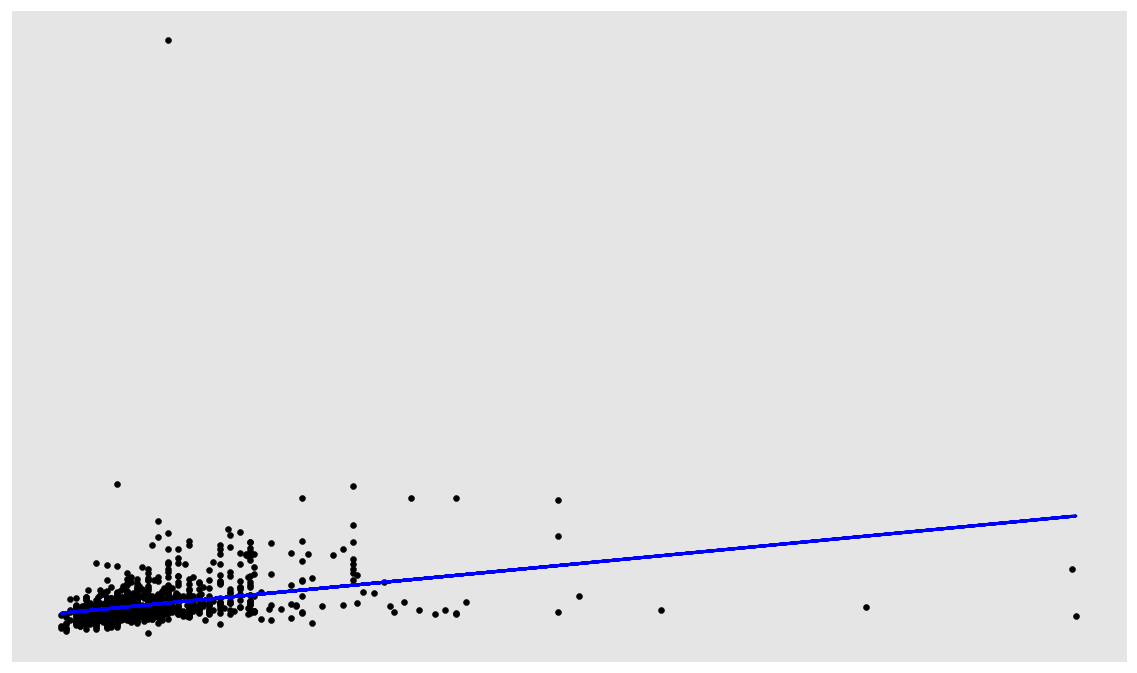

In [62]:
from sklearn import linear_model
# Create linear regression object
reg = linear_model.LinearRegression()

x = test['rent_per_week'].values.reshape(-1,1)
y = np.array(rfr_predicted)

# Train the model using the training sets
reg.fit(x, y)
# The coefficients
print('Coefficients: \n', reg.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((reg.predict(x) - y) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % reg.score(x, y))

# Plot outputs
plt.scatter(x, y,  color='black')
plt.plot(x, reg.predict(x), color='blue',
         linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()